iteration  1  accuracy:  0.37352380952380954
iteration  2  accuracy:  0.12097619047619047
iteration  3  accuracy:  0.3613571428571429
iteration  4  accuracy:  0.45654761904761904
iteration  5  accuracy:  0.6405238095238095
iteration  6  accuracy:  0.6758333333333333
iteration  7  accuracy:  0.6908095238095238
iteration  8  accuracy:  0.7092857142857143
iteration  9  accuracy:  0.7525238095238095
iteration  10  accuracy:  0.7893809523809524
Final cross-entropy loss is 0.82403982
Final training accuracy is 78.9381%


/tmp/ipykernel_32030/3529205213.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(W).shape, np.array(b).shape)


(2,) (1, 256)


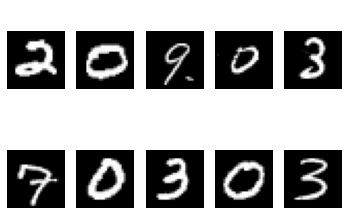

In [17]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")

# Set up the data
y_train = train_data['label'].values
X_train = train_data.drop(columns=['label']).values/255
X_test = test_data.values/255


def relu(x):
    x[x < 0] = 0
    return x


def h(X, W, b):
    '''
    Hypothesis function: simple FNN with 1 hidden layer
    Layer 1: input
    Layer 2: hidden layer, with a size implied by the arguments W[0], b
    Layer 3: output layer, with a size implied by the arguments W[1]
    '''
    # layer 1 = input layer
    a1 = X
    # layer 1 (input layer) -> layer 2 (hidden layer)
    z1 = np.matmul(X, W[0]) + b[0]

    # add one more layer

    # layer 2 activation
    a2 = relu(z1)
    # layer 2 (hidden layer) -> layer 3 (output layer)
    z2 = np.matmul(a2, W[1])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1, 1)
    sigma = s/total
    # the output is a probability for each sample
    return sigma


def softmax(X_in, weights):
    '''
    Un-used cell for demo
    activation function for the last FC layer: softmax function 
    Output: K probabilities represent an estimate of P(y=k|X_in;weights) for k=1,...,K
    the weights has shape (n, K)
    n: the number of features X_in has
    n = X_in.shape[1]
    K: the number of classes
    K = 10
    '''

    s = np.exp(np.matmul(X_in, weights))
    total = np.sum(s, axis=1).reshape(-1, 1)
    return s / total


def loss(y_pred, y_true):
    '''
    Loss function: cross entropy with an L^2 regularization
    y_true: ground truth, of shape (N, )
    y_pred: prediction made by the model, of shape (N, K) 
    N: number of samples in the batch
    K: global variable, number of classes
    '''
    global K
    K = 10
    N = len(y_true)
    # loss_sample stores the cross entropy for each sample in X
    # convert y_true from labels to one-hot-vector encoding
    y_true_one_hot_vec = (y_true[:, np.newaxis] == np.arange(K))
    loss_sample = (np.log(y_pred) * y_true_one_hot_vec).sum(axis=1)
    # loss_sample is a dimension (N,) array
    # for the final loss, we need take the average
    return -np.mean(loss_sample)


def backprop(W, b, X, y, alpha=1e-4):
    '''
    Step 1: explicit forward pass h(X;W,b)
    Step 2: backpropagation for dW and db
    '''
    K = 10
    N = X.shape[0]

    # Step 1:
    # layer 1 = input layer
    a1 = X
    # layer 1 (input layer) -> layer 2 (hidden layer)
    z1 = np.matmul(X, W[0]) + b[0]
    # layer 2 activation
    a2 = relu(z1)

    # one more layer

    # layer 2 (hidden layer) -> layer 3 (output layer)
    z2 = np.matmul(a2, W[1])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1, 1)
    sigma = s/total

    # Step 2:

    # layer 2->layer 3 weights' derivative
    # delta2 is \partial L/partial z2, of shape (N,K)
    y_one_hot_vec = (y[:, np.newaxis] == np.arange(K))
    delta2 = (sigma - y_one_hot_vec)
    grad_W1 = np.matmul(a2.T, delta2)

    # layer 1->layer 2 weights' derivative
    # delta1 is \partial a2/partial z1
    # layer 2 activation's (weak) derivative is 1*(z1>0)
    delta1 = np.matmul(delta2, W[1].T)*(z1 > 0)
    grad_W0 = np.matmul(X.T, delta1)

    # Student project: extra layer of derivative

    # no derivative for layer 1

    # the alpha part is the derivative for the regularization
    # regularization = 0.5*alpha*(np.sum(W[1]**2) + np.sum(W[0]**2))

    dW = [grad_W0/N + alpha*W[0], grad_W1/N + alpha*W[1]]
    db = [np.mean(delta1, axis=0)]
    # dW[0] is W[0]'s derivative, and dW[1] is W[1]'s derivative; similar for db
    return dW, db


eta = 5e-1
alpha = 1e-6  # regularization
gamma = 0.99  # RMSprop
eps = 1e-3  # RMSprop
num_iter = 10  # number of iterations of gradient descent
n_H = 256  # number of neurons in the hidden layer
n = X_train.shape[1]  # number of pixels in an image
K = 10

# initialization
np.random.seed(1127)
W = [1e-1*np.random.randn(n, n_H), 1e-1*np.random.randn(n_H, K)]
b = [np.random.randn(n_H)]

gW0 = gW1 = gb0 = 1

acc_array = []

for i in range(num_iter):
    dW, db = backprop(W, b, X_train, y_train, alpha)

    gW0 = gamma*gW0 + (1-gamma)*np.sum(dW[0]**2)
    etaW0 = eta/np.sqrt(gW0 + eps)
    W[0] -= etaW0 * dW[0]

    gW1 = gamma*gW1 + (1-gamma)*np.sum(dW[1]**2)
    etaW1 = eta/np.sqrt(gW1 + eps)
    W[1] -= etaW1 * dW[1]

    gb0 = gamma*gb0 + (1-gamma)*np.sum(db[0]**2)
    etab0 = eta/np.sqrt(gb0 + eps)
    b[0] -= etab0 * db[0]

    y_pred = h(X_train, W, b)
    accuracy = np.mean(np.argmax(y_pred, axis=1) == y_train)
    print("iteration ", i+1, " accuracy: ", accuracy)
    acc_array.append(accuracy)

    # reset RMSprop
    gW0 = gW1 = gb0 = 1

y_pred_final = h(X_train, W, b)
print("Final cross-entropy loss is {:.8}".format(loss(y_pred_final, y_train)))
print("Final training accuracy is {:.4%}".format(
    np.mean(np.argmax(y_pred_final, axis=1) == y_train)))

y_pred_test_default = np.argmax(h(X_test, W, b), axis=1)

fig_res, axes_res = plt.subplots(2, 5)
axes_res = axes_res.flatten()

plt.plot(acc_array)

for i in range(10):
    axes_res[i].imshow(X_test[i, :].reshape(28, 28), cmap='gray')
    axes_res[i].axis('off')  # hide the axes ticks
    axes_res[i].set_title(str(int(y_pred_test_default[i])),
                          color='white', fontsize=25)


In [18]:
np.savez_compressed('./model_compressed', weights = np.array(W), biases = np.array(b))


/tmp/ipykernel_32030/1274019874.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.savez_compressed('./model_compressed', weights = np.array(W), biases = np.array(b))


Text(0.5, 1.0, '2')

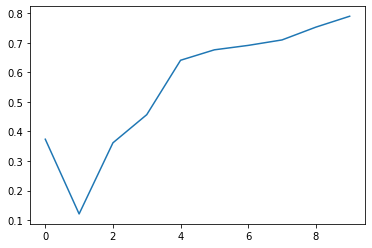

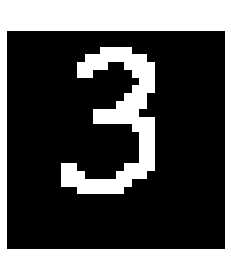

In [19]:
from PIL import Image
import numpy as np
from numpy import asarray

import matplotlib.pyplot as plt

image = Image.open('./img3.png')

img_arr = asarray(image)[:, :, 0].flatten()

loaded = np.load('./model_compressed.npz', allow_pickle=True)

y_pred_test = np.argmax(
    h(np.array([img_arr]), loaded["weights"], loaded["biases"]), axis=1)

plt.plot(acc_array)
fig_res, axes_res = plt.subplots(1, 1)

axes_res.imshow(img_arr.reshape(28, 28), cmap='gray')
axes_res.axis('off')  # hide the axes ticks
axes_res.set_title(str(int(y_pred_test[0])), color='white', fontsize=25)
